In [14]:
import pickle
import time
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
lr = 0.001
batch_size = 4096
iterations = 20001
print_every = 2000 
hidden_dim = 512
load_checkpoint = 1999
# Model class
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)



checkpoint_steps = [load_checkpoint+i * 200 for i in range(10)]
with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step{load_checkpoint}.pkl', 'rb') as f:
    raw_models_grads = pickle.load(f)
# checkpoint_steps = [1999, 3999, 5999, 7999, 9999, 11999, 13999, 15999, 17999, 19999]
# checkpoint_steps = [199, 399, 599, 799, 999, 1199, 1399, 1599, 1799, 1999]
module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                   "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                   "main.8.weight", "main.8.bias"]
# checkpoint_steps = [1999,7999,13999,19999]
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
if load_checkpoint!= 0:
    state_dict_path = f'/home/u5649209/workspace/flow_matching/ckpts/raw_models/raw_model_{load_checkpoint}.pth'
    state_dict = torch.load(state_dict_path, map_location=device)
    vf.load_state_dict(state_dict)
distance_module_dict = {}
for ckpt in checkpoint_steps:

    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/raw_models/raw_model_{ckpt}.pth'
    
    original_weights = vf.state_dict()
    loaded_weights = torch.load(weight_path, map_location=device)
    
    learning_rate_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20]
    
    for module in module_list:
        
        if 'bias' in module:
            continue
        weights = loaded_weights[module].to(device)
        gradients = raw_models_grads[module].to(device)
        for lr in learning_rate_list:
            # Reset model weights
            ori_module_weights= original_weights[module].to(device)
            after_optimization_weights = ori_module_weights + lr * gradients[0]
            # distance = torch.norm(after_optimization_weights - weights).item()
            # distance = wasserstein_distance(after_optimization_weights.cpu().numpy().flatten(), weights.cpu().numpy().flatten())
            dot_product = np.dot(after_optimization_weights.flatten().cpu().numpy(), weights.flatten().cpu().numpy())
            norm_after = np.linalg.norm(after_optimization_weights.flatten().cpu().numpy())
            norm_weights = np.linalg.norm(weights.flatten().cpu().numpy())
            distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180
            # Print the step, module, learning rate, and distance
            # print(f"Step: {step}, Module: {module}, LR: {lr}, Distance: {distance}")
            print(f"Step: {ckpt}, Module: {module}, LR: {lr}, Distance: {distance}")
            distance_module_dict[(ckpt, module, lr)] = distance



Using gpu
Step: 1999, Module: main.0.weight, LR: 1e-05, Distance: 0.0
Step: 1999, Module: main.0.weight, LR: 0.0001, Distance: 0.0
Step: 1999, Module: main.0.weight, LR: 0.001, Distance: 0.0
Step: 1999, Module: main.0.weight, LR: 0.01, Distance: 0.0
Step: 1999, Module: main.0.weight, LR: 0.1, Distance: 0.0
Step: 1999, Module: main.0.weight, LR: 1, Distance: 0.1297215074300766
Step: 1999, Module: main.0.weight, LR: 10, Distance: 1.2825266122817993
Step: 1999, Module: main.0.weight, LR: 20, Distance: 2.563000202178955
Step: 1999, Module: main.2.weight, LR: 1e-05, Distance: 0.0
Step: 1999, Module: main.2.weight, LR: 0.0001, Distance: 0.0
Step: 1999, Module: main.2.weight, LR: 0.001, Distance: 0.0
Step: 1999, Module: main.2.weight, LR: 0.01, Distance: 0.0
Step: 1999, Module: main.2.weight, LR: 0.1, Distance: 0.0
Step: 1999, Module: main.2.weight, LR: 1, Distance: 0.1724584996700287
Step: 1999, Module: main.2.weight, LR: 10, Distance: 1.7263509035110474
Step: 1999, Module: main.2.weight, LR

## distance vs lr

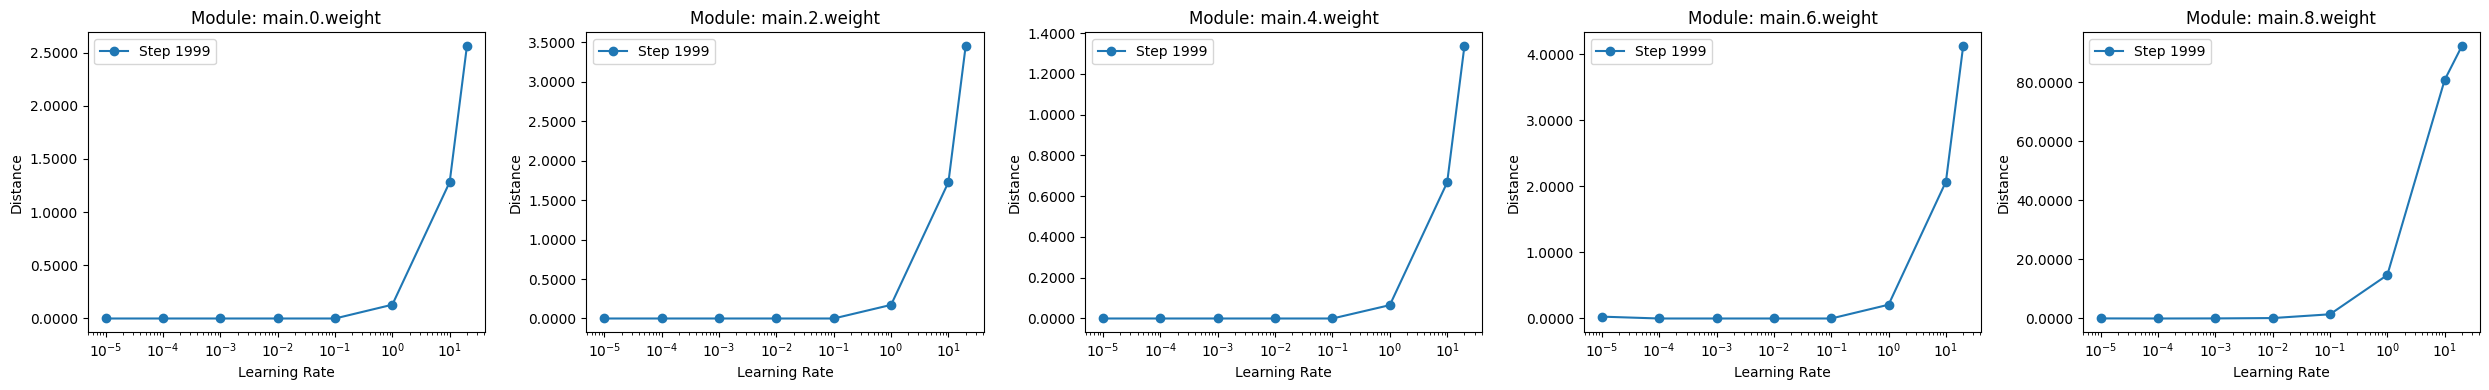

In [15]:
# Plot
fig, axs = plt.subplots(1, len([m for m in module_list if 'bias' not in m]), figsize=(5 * len([m for m in module_list if 'bias' not in m]), 4))
if len([m for m in module_list if 'bias' not in m]) == 1:
    axs = [axs]
for idx, module in enumerate([m for m in module_list if 'bias' not in m]):
    distances = [distance_module_dict[(1999, module, lr)] for lr in learning_rate_list]
    axs[idx].plot(learning_rate_list, distances, marker='o', label=f"Step 1999")
    
    axs[idx].set_xscale("log")
    axs[idx].set_xlabel("Learning Rate")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module}")
    axs[idx].legend()
    axs[idx].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.4f}"))
plt.tight_layout()
plt.savefig("distance_vs_lr.png")
plt.show()

## Distance vs Step under learning rate = 1.0

0.1297215


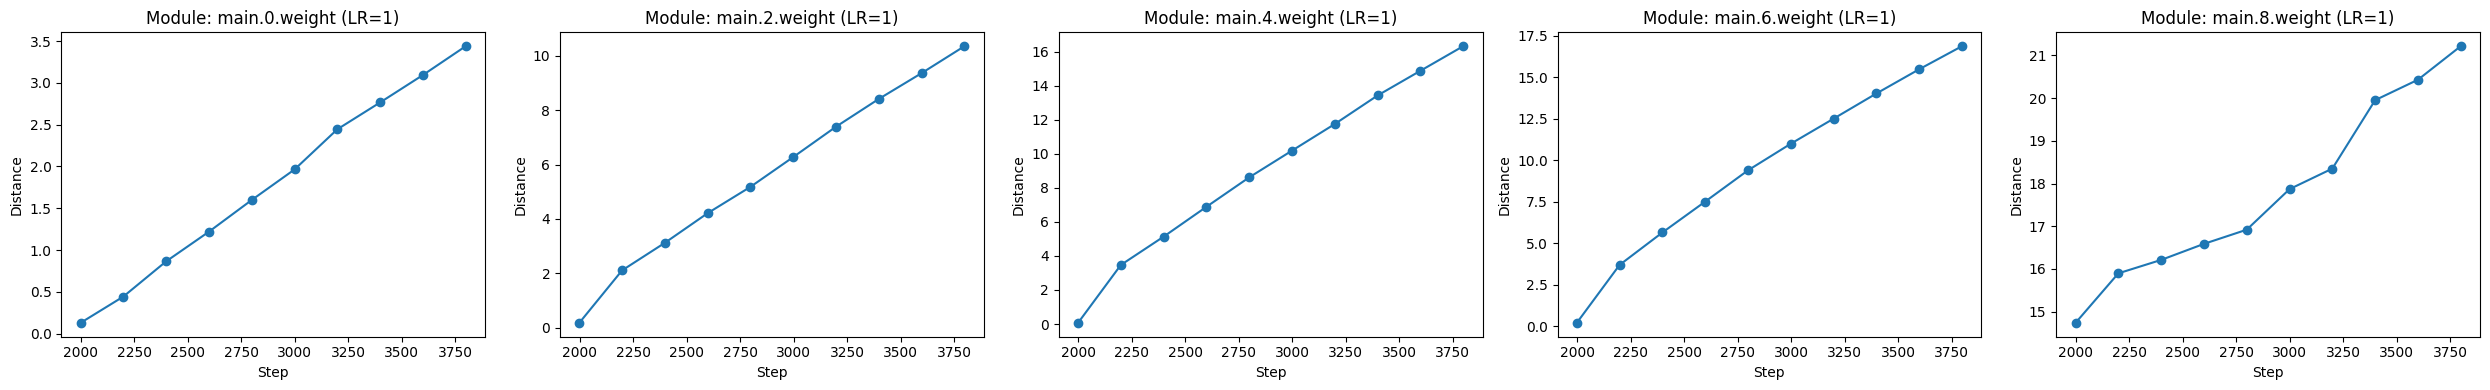

In [16]:
# Plot distance vs step for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]
for idx, module in enumerate(modules):
    steps = checkpoint_steps
    distances = [distance_module_dict[(step, module, lr_fixed)] for step in steps]
    axs[idx].plot(steps, distances, marker='o')
    axs[idx].set_xlabel("Step")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
print(distance_module_dict[(1999, 'main.0.weight', 1)])
plt.tight_layout()
plt.savefig("distance_vs_step_lr1.png")
plt.show()

## Theorem 3.1 verification

In [ ]:
# reinit lora utils, loraGA
from tqdm import tqdm
from peft.tuners.lora import LoraLayer
@torch.no_grad()
def reinit_lora_modules(name, module, init_config, additional_info):
    r"""
    Reinitialize the lora model with the given configuration.
    """
    lora_r = min(module.lora_A.default.weight.shape)

    named_grad = additional_info["named_grads"]
    print("*************************")
    print(name)
    grad_name = name + '.weight'
    grads = named_grad[grad_name]

    init_config['direction'] == "LoRA-GA":
    m, n = grads.shape
    print(m,n)
    U, S, V = torch.linalg.svd(grads.float())
    B = U[:, lora_r : 2 * lora_r]
    A = V[:lora_r, :]
    m, n = grads.shape # m: feature_out, n: feature_in
    # the scale of output is only related to the feature_out
    gamma = init_config["stable_gamma"]
    B = B * m**0.25 / gamma**0.5
    A = A * m**0.25 / gamma**0.5

    module.lora_B.default.weight = torch.nn.Parameter(B.contiguous().cuda())
    module.lora_A.default.weight = torch.nn.Parameter(A.contiguous().cuda())


    
    return
def reinit_lora(model, init_config, additional_info):
    r"""
    Reinitialize the lora model with the given configuration.
    """
    inited_modules = []
    for name, module in tqdm(
        model.named_modules(),
        desc="Reinitializing Lora",
        total=len(list(model.named_modules())),
    ):
        
        if isinstance(module, LoraLayer):
            if_init = reinit_lora_modules(name, module, init_config, additional_info)
            if if_init:
                inited_modules.append(name)
    pass
    return model, inited_modules

In [ ]:
from peft import LoraConfig, get_peft_model
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf = get_peft_model(vf, lora_config)



## Theorem 3.2 verification